<a href="https://colab.research.google.com/github/duane-edgington/google-multispecies-whale-detection/blob/main/NEW_duane_24kHzDecimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>
    
  * Distributed under the terms of the GPL License
  * Maintainer: yzhang@mbari.org
  * Authors: Yanwu Zhang yzhang@mbari.org, Paul McGill mcgill@mbari.org, Danelle Cline (dcline@mbari.org), John Ryan ryjo@mbari.org
  * bug fixes March 11, 2025 Duane Edgington duane@mbari.org

## Decimation of MARS hydrophone data

An extensive (6+ years and growing) archive of sound recordings from a deep-sea location [along the eastern margin of the North Pacific Ocean](https://www.mbari.org/at-sea/cabled-observatory/) has been made available through AWS Open data.  Temporal coverage of the recording archive has been 95% since project inception in July 2015.  The original recordings have a sample rate of 256 kHz. Many research topics can be effectively studied using data with a lower sample rate, and this Open Data project includes daily files decimated to 2 kHz and 16 kHz.  The purpose of this notebook is to illustrate a method of optimizing decimation processing, which is applicable to any desired sample rate. The demonstration uses Python, but the algorithms can be implemented in other languages.

This method enables design of the optimal windowed-sinc anti-aliasing low-pass filter (using a certain window) that meets the desired passband and stopband requirements based on signal retention and exclusion needs. The best combination of the sinc function’s cutoff frequency and the main-lobe bandwidth of the window function generates the shortest qualifying filter.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**


## Data Overview
The full-resolution audio data are in [WAV](https://en.wikipedia.org/wiki/WAV) format in s3 buckets named <b>pacific-sound-256khz-yyyy</b>, where yyyy is 2015 or later.  Buckets are stored as objects, so the data aren't physically stored in folders or directories as you may be familiar with, but you can think of it conceptually as follows:

```
pacific-sound-256khz-2021
      |
      individual 10-minute files
```


## Install required dependencies

First, let's install the required software dependencies.

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed.

In [ ]:
!pip install -q boto3 --quiet
!pip install -q soundfile --quiet
!pip install -q scipy --quiet
!pip install -q numpy --quiet
!pip install -q matplotlib --quiet

!apt-get install -qq sox
!apt-get install -qq libsox-fmt-mp3
!pip install -qq git+https://github.com/rabitt/pysox.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.5 MB/s eta 0:00:00
Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libsox3:amd64.
Preparing to unpack .../2-libsox3_14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1_amd64.deb ...
Unpacking libsox3:amd64 (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1) ...
Selecting previously unselected package libsox-fmt-alsa:amd64.
Preparing to unpack .../3-libsox-fmt-alsa_

### Import all packages

In [ ]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import math
import scipy
from scipy import signal, interpolate
import scipy.signal as signal
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

import time
from datetime import timedelta

import os
import shutil

import librosa.display



## List the contents of a monthly directory

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True) # This will prompt for authorization.

Mounted at /content/drive


In [ ]:
# Record the start time
start_time = time.time()

In [ ]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))

In [ ]:
bucket = 'pacific-sound-256khz-2018'

for i, obj in enumerate(s3.list_objects_v2(Bucket=bucket)['Contents']):
  print(obj['Key'])
  if i > 20:
      break

01/MARS_20180101_000406.wav
01/MARS_20180101_001406.wav
01/MARS_20180101_002406.wav
01/MARS_20180101_003406.wav
01/MARS_20180101_004406.wav
01/MARS_20180101_005406.wav
01/MARS_20180101_010406.wav
01/MARS_20180101_011406.wav
01/MARS_20180101_012406.wav
01/MARS_20180101_013406.wav
01/MARS_20180101_014406.wav
01/MARS_20180101_015406.wav
01/MARS_20180101_020406.wav
01/MARS_20180101_021406.wav
01/MARS_20180101_022406.wav
01/MARS_20180101_023406.wav
01/MARS_20180101_024406.wav
01/MARS_20180101_025406.wav
01/MARS_20180101_030406.wav
01/MARS_20180101_031406.wav
01/MARS_20180101_032406.wav
01/MARS_20180101_033406.wav


## Read metadata from a file

In [ ]:
bucket = 'pacific-sound-256khz-2018'

#basefilename = 'MARS_20180413_085913' #this file has no orcas or anything else
#basefilename = 'MARS_20180413_065913' #this file has many orca calls
#basefilename = 'MARS_20180430_012912' #mammal calls, not orcas?
basefilename = 'MARS_20180430_032912' #no Oo, maybe Bm...
#basefilename = 'MARS_20180413_070913' #Oo in last 33 seconds
#basefilename = ''

basename = f'{basefilename}.wav'
filename = f'04/{basename}'
url = f'https://{bucket}.s3.amazonaws.com/{filename}'
print(f'Reading metadata from {url}')
sf.info(io.BytesIO(urlopen(url).read(1000)), verbose=True)

Reading metadata from https://pacific-sound-256khz-2018.s3.amazonaws.com/04/MARS_20180430_032912.wav


samplerate: 256000 Hz
channels: 1
duration: 214 samples
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 214
extra_info: """
    Length : 1000
    RIFF : 460800348 (should be 992)
    WAVE
    LIST : 304
      INFO
        IART : icListen HF #1689
        IPRD : RB9-ETH R4
        ICRD : 2018-04-29T20:29:12-07
        ISFT : Lucy V4.3.0
        INAM : MARS_20180430_032912.wav
        ICMT : 3.000000 V pk, -177 dBV re 1uPa, 42.1 % RH,  6.1 deg C, 8388608 = Max Count
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 256000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 768000
    data : 460800000 (should be 644)
    End
    """

## Read data from a file

In [ ]:
print(f'Reading data from {url}')
x, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')

Reading data from https://pacific-sound-256khz-2018.s3.amazonaws.com/04/MARS_20180430_032912.wav


In [ ]:
import requests
import os

def save_file_from_url(url, save_path):
    """
    Fetches a file from a URL and saves it to the specified local path.

    :param url: The URL of the file to be fetched.
    :param save_path: The local path where the file should be saved.
    :return: None
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)

        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Write the content to the local file
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"File saved successfully to {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch the file from {url}: {e}")
    except IOError as e:
        print(f"Failed to save the file to {save_path}: {e}")

## Example usage:
#url = "https://example.com/path/to/your/file.zip"
#ave_path = "path/to/save/your/file.zip"
#save_file_from_url(url, save_path)

In [ ]:
#write the file locally for plotting and for resampling
sf.write(f'/content/256000_{basename}', x, int(sample_rate))

## Utilities to manipulate files and directories

In [ ]:
def copy_files(src_dir, dst_dir):
    """
    Copies all files from the source directory to the destination directory.

    :param src_dir: Path to the source directory.
    :param dst_dir: Path to the destination directory.
    """
    # Ensure the source directory exists
    if not os.path.exists(src_dir):
        print(f"Source directory '{src_dir}' does not exist.")
        return

    # Create the destination directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Iterate over all files in the source directory
    for filename in os.listdir(src_dir):
        src_file_path = os.path.join(src_dir, filename)
        dst_file_path = os.path.join(dst_dir, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(src_file_path):
            print(f"Copying {src_file_path} to {dst_file_path}")
            shutil.copy2(src_file_path, dst_file_path)
        else:
            print(f"Skipping {src_file_path} (not a file)")

# Example usage:
# copy_files('/path/to/source_directory', '/path/to/destination_directory')

In [ ]:
def copy_file(source_dir, destination_dir, filename):
    """
    Copies a file from the source directory to the destination directory.

    :param source_dir: The directory where the file is currently located.
    :param destination_dir: The directory where the file will be copied to.
    :param filename: The name of the file to be copied.
    """
    # Construct the full file paths
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)

    # Check if the source file exists
    if not os.path.exists(source_file_path):
        print(f"Error: The file '{filename}' does not exist in '{source_dir}'.")
        return

    # Check if the destination directory exists, if not, create it
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Copy the file
    shutil.copy2(source_file_path, destination_file_path)
    print(f"File '{filename}' copied from '{source_dir}' to '{destination_dir}'.")

# Example usage:
# copy_file('/path/to/source/directory', '/path/to/destination/directory', 'example.txt')

In [ ]:
def rename_file(old_full_path, new_full_path):
    """
    Renames a file from the old full path to the new full path.

    :param old_full_path: The current full path of the file (including the file name).
    :param new_full_path: The new full path for the file (including the new file name).
    """
    try:
        # Check if the old file exists
        if not os.path.exists(old_full_path):
            print(f"Error: The file '{old_full_path}' does not exist.")
            return

        # Check if the new file already exists
        if os.path.exists(new_full_path):
            print(f"Error: The file '{new_full_path}' already exists.")
            return

        # Rename the file
        os.rename(old_full_path, new_full_path)
        print(f"File renamed successfully from '{old_full_path}' to '{new_full_path}'.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# rename_file('/path/to/old_filename.txt', '/path/to/new_filename.txt')

In [ ]:
def process_file(file_name):
    # Replace this with your actual file processing logic
    print(f"Processing file: {file_name}")
    # Example: Open and read the file
    try:
        with open(file_name, 'r') as file:
            content = file.read()
            print(f"Content of {file_name}:\n{content}")
    except FileNotFoundError:
        print(f"File {file_name} not found.")

In [ ]:
def main_file_loop():
    # Path to the external file containing file names
    file_list_path = 'file_names.txt'

    try:
        # Open the file and read the file names
        with open(file_list_path, 'r') as file:
            file_names = file.read().splitlines()

        # Loop through each file name and call the process_file procedure
        for file_name in file_names:
            process_file(file_name)

    except FileNotFoundError:
        print(f"The file {file_list_path} was not found.")

## Produce a spectrogram

First, plot a standard MEL spectrogram

In [ ]:
def plot_mel_spectrogram(audio_path, sr=None, n_fft=2048, hop_length=512, n_mels=128):
    """
    Plots the MEL spectrogram of an audio file.

    Parameters:
    - audio_path: Path to the audio file.
    - sr: Sampling rate of the audio file. If None, librosa's default will be used.
    - n_fft: Length of the FFT window. number of samples in a window per fft
    - hop_length: Number of samples between successive frames.
    - n_mels: Number of MEL bands to generate.
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Compute the MEL spectrogram
    ## reduced the n_mels by half to eliminate "Empty filters detected in mel frequency" warning
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels/2)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot the MEL spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MEL Spectrogram')
    plt.xlabel('Minutes')
    plt.ylabel('Frequency (Hz)')
    plt.savefig(f'MEL_{basefilename}.png')
    plt.tight_layout()
    plt.show()



## Example usage
#audio_file_path = 'path_to_your_audio_file.wav'
#plot_mel_spectrogram(audio_file_path)

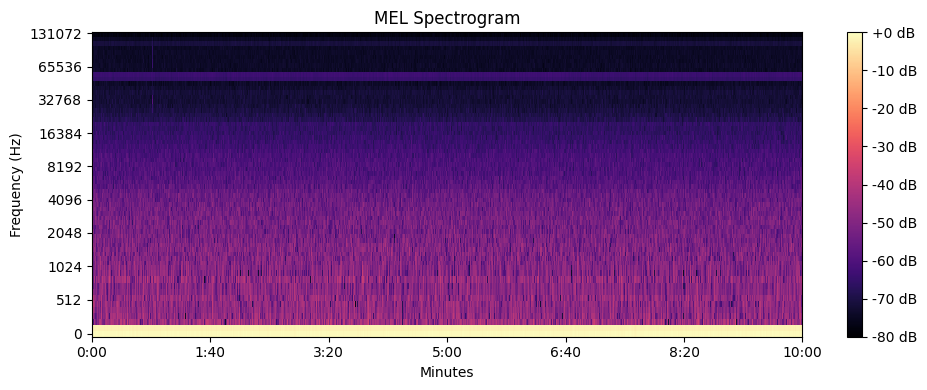

In [ ]:
audio_file_path = f'/content/256000_{basename}'
plot_mel_spectrogram(audio_file_path)

In [ ]:
# save the spectrogram
#copy_file('/content','/content/drive/MyDrive/audio_spectrograms',f'MEL_{basefilename}.png')

### Calibrated Spectrum Levels

### Calibration metadata
Frequency-dependent hydrophone sensitivity data are defined in the following files, one for each deployment:
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

### Compute spectrogram




In [ ]:
# convert scaled voltage to volts
v = x*3
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 1  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

600 segments of length 1 seconds in 600.0 seconds of audio


In [ ]:
lenfft_input = 2**int(np.ceil(np.log2(sample_rate)))
print(lenfft_input)
#
# initialize empty LTSA
nfreq = int(lenfft_input/2+1)
sg_input = np.empty((nfreq, nseg), float)
sg_input.shape

262144


(131073, 600)

In [ ]:
# get window
w_input = scipy.signal.get_window('blackman',sample_rate)
window_correction = np.mean(np.square(w_input))
#
numDataPoints_input = int(sample_rate*spa)
#
Ind_keep = np.arange(0, int(lenfft_input/2)+1)
f_input = (Ind_keep/lenfft_input) * sample_rate
#
# Calculate spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
#  f,psd = scipy.signal.welch(v[cstart:cend], fs=sample_rate, window=w_input, nfft=sample_rate)
  psd_input = np.square(np.absolute(np.fft.fft(np.multiply(v[cstart:cend],w_input), n=lenfft_input)))/(numDataPoints_input*window_correction)/sample_rate
  psd_input_log10 = 10*np.log10(psd_input[Ind_keep])
  sg_input[:,x] = psd_input_log10
  if (x == 0):
    psd_input_check = psd_input
    print("Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:")
    print(np.mean(np.square(v[cstart:cend])))
    print(sum(psd_input_check)*(sample_rate/lenfft_input))

Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:
0.00011910775
0.00012104793544327926


### Apply calibration
Frequency-dependent hydrophone sensitivity data are reported in the json files identified above.  This example file is from the second hydrophone deployment, for which the calibration data are manually entered below.  Note that the lowest measured value, at 250 Hz, is assumed to cover lower frequencies and repeated as a value at 0 Hz to allow interpolation to the spectrogram output frequencies across the full frequency range.



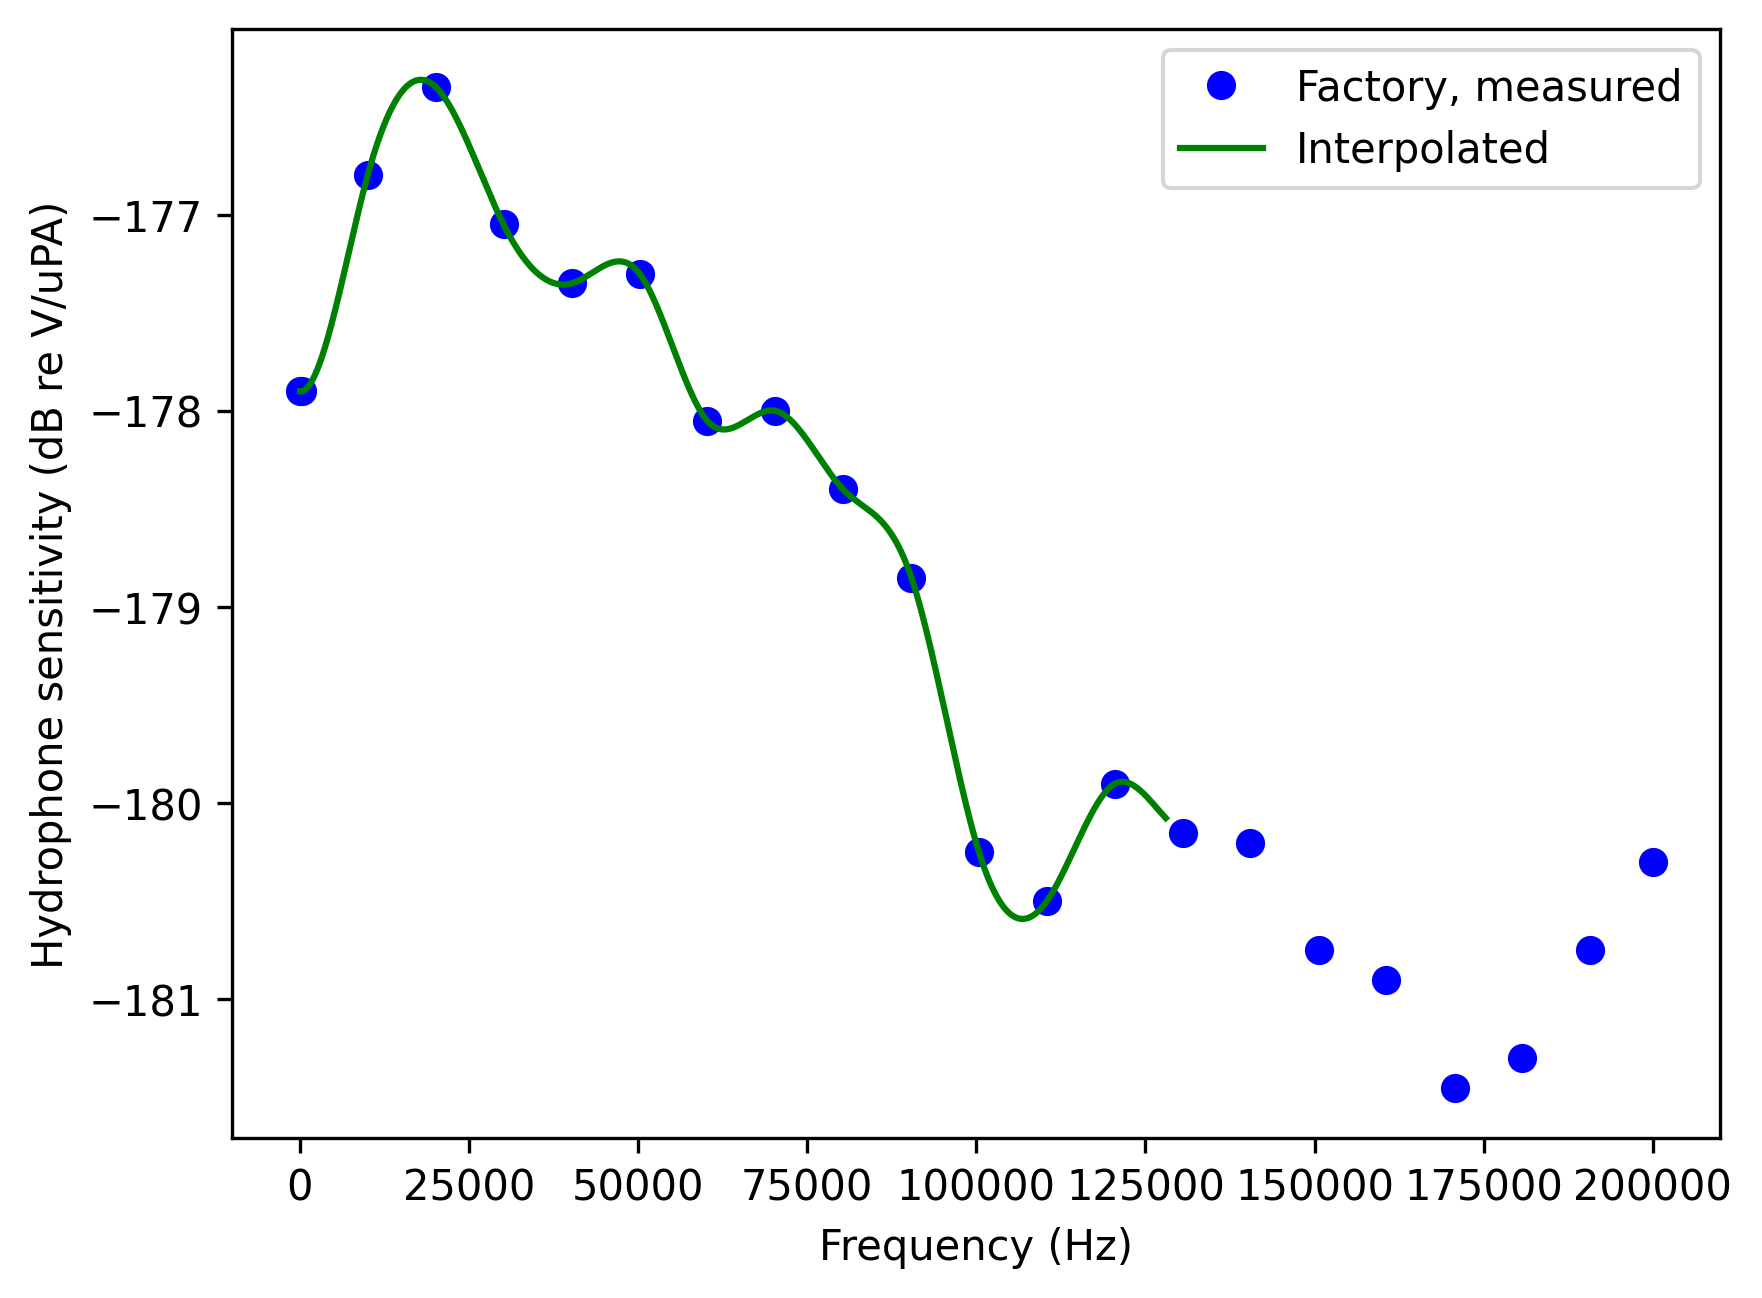

In [ ]:
# define hydrophone calibration data
calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

# interpolate to the frequency resolution of the spectrogram
tck = interpolate.splrep(calfreq, calsens, s=0)
isens = interpolate.splev(f_input, tck, der=0)
plt.figure(dpi=300)
im = plt.plot(calfreq,calsens,'bo',f_input,isens,'g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hydrophone sensitivity (dB re V/uPA)')
plt.legend(['Factory, measured', 'Interpolated'])


In [ ]:
# replicate interpolated sensitivity
isensg = np.transpose(np.tile(isens,[nseg,1]))
isensg.shape

(131073, 600)

In [ ]:
sg_input.shape

(131073, 600)

### Plot the calibrated spectrogram

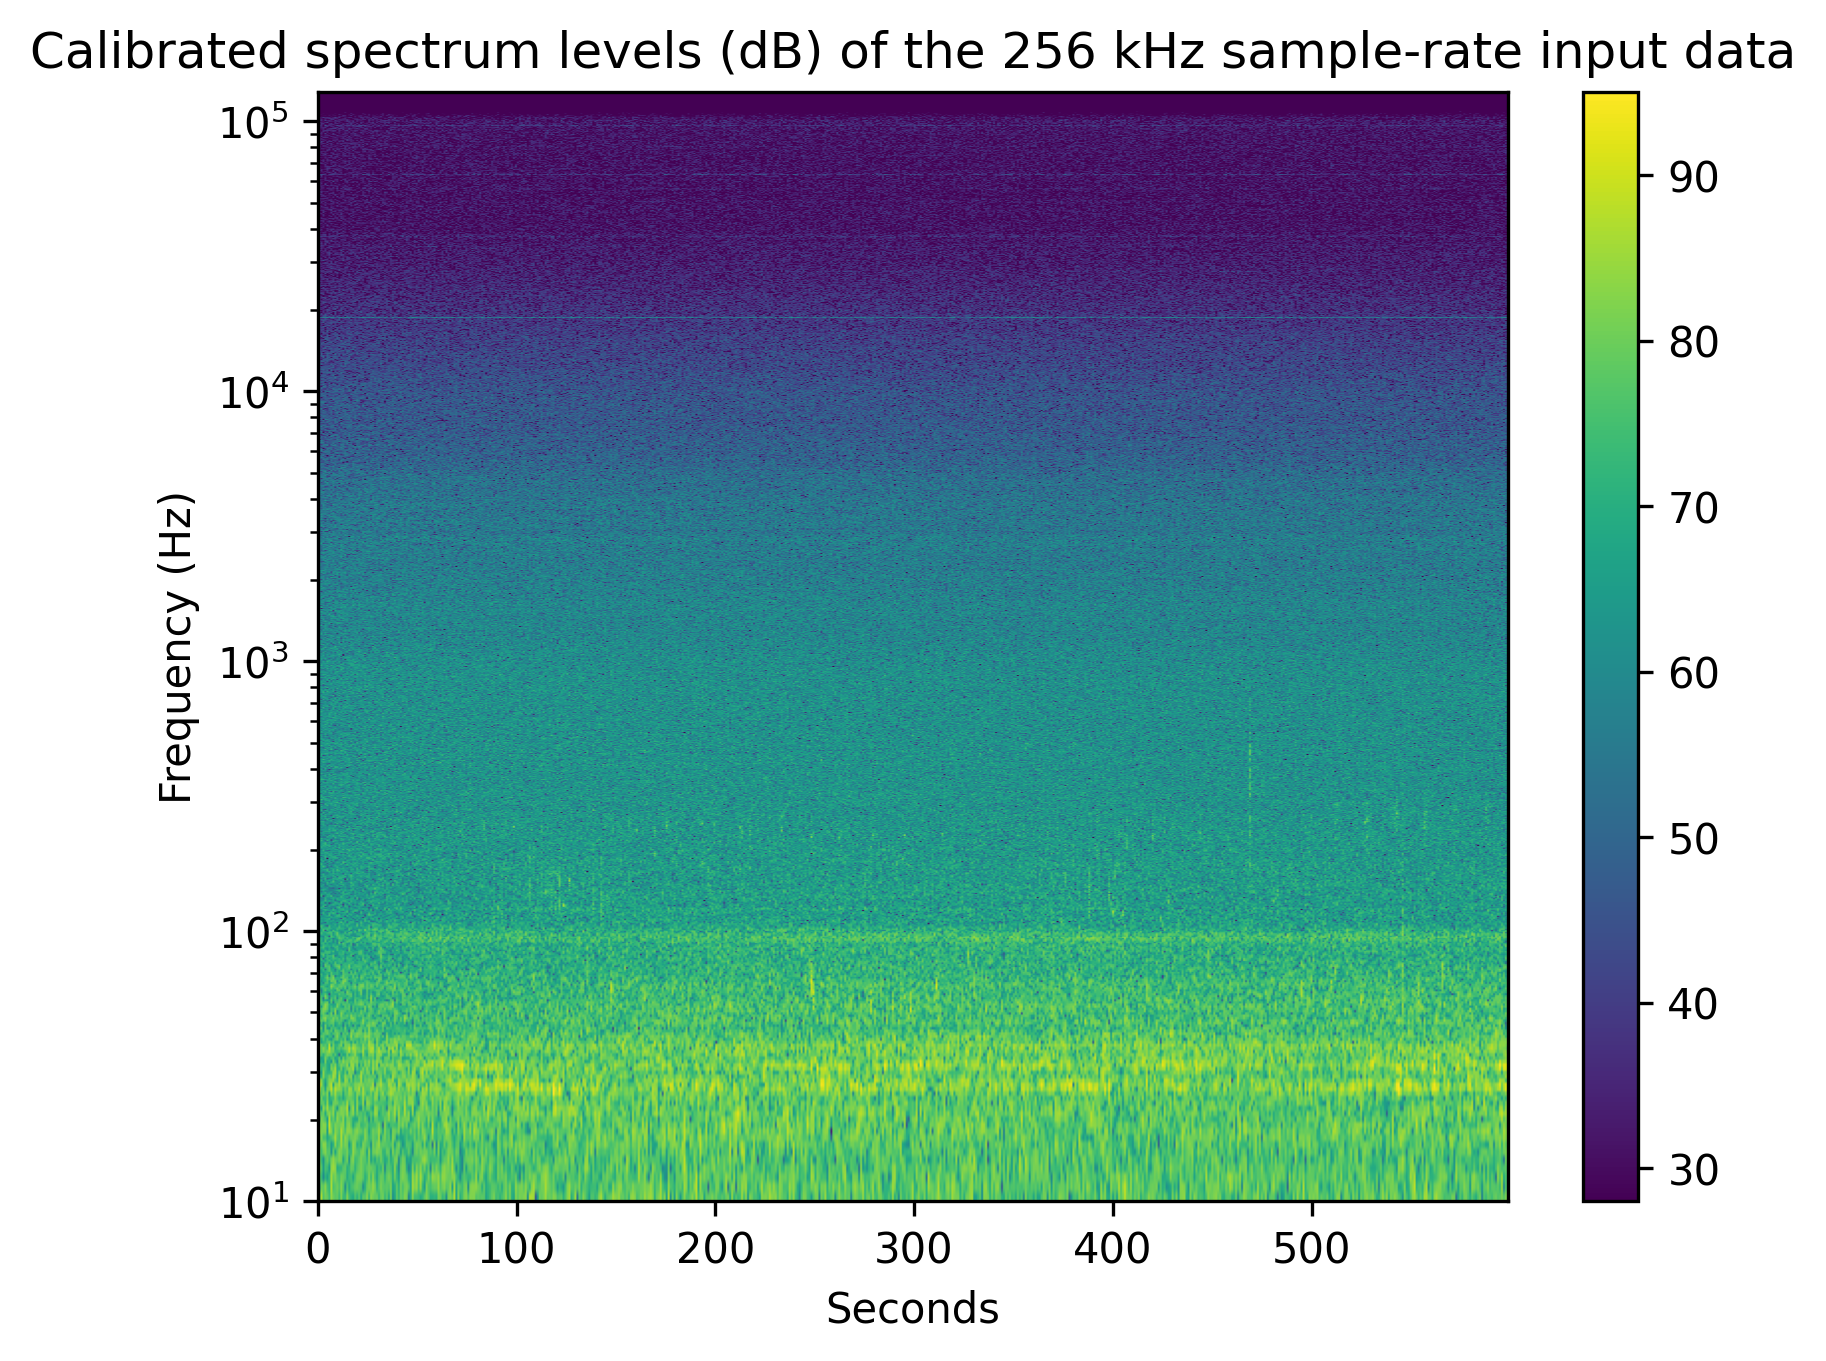

In [ ]:
plt.figure(dpi=300)
Extent = [0, nseg-1, 0.0, sample_rate/2.0]
im = plt.imshow(sg_input-isensg, extent=Extent, aspect='auto',origin='lower',vmin=28,vmax=95)
plt.yscale('log')
plt.ylim(10,128000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels (dB) of the 256 kHz sample-rate input data')
plt.savefig(f'256kHz_{basefilename}.png')

In [ ]:
#save the detailed spectrogram
#copy_file('/content', '/content/drive/MyDrive/audio_spectrograms',f'256kHz_{basefilename}.png')

## do downsample step with SoX to subsample to 24kHz

In [ ]:
import sox

from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
#%matplotlib inline


def downsample_audio(input_file, output_file, original_sr=25600, target_sr=24000):
    """
    downsamples an audio file from original_sr to target_sr .

    SoX provides a resampling function that is designed to minimize spectral artifacts during the resampling process

    Parameters:
    - input_file: Path to the input audio file.
    - output_file: Path to save the decimated audio file.
    - original_sr: Original sample rate (default: 25.6 kHz).
    - target_sr: Desired output sample rate (default: 24 kHz).
    """
    #use SoX to decimate/resample the audio data directly. the -v flag is for very high quality.
    !sox {input_file} {output_file} rate -v {target_sr}

    print(f"Audio resampled from {original_sr}Hz to {target_sr}Hz and saved to {output_file}")


In [ ]:
target_sr = 24000
original_sr =sample_rate
downsample_audio(f'/content/256000_{basename}',f'/content/24kHz_{basename}', original_sr=original_sr, target_sr=target_sr)

Audio resampled from 256000Hz to 24000Hz and saved to /content/24kHz_MARS_20180430_032912.wav


In [ ]:
#copy_file('/content', '/content/drive/MyDrive/pacific-sound',f'25600_{basename}')
copy_file('/content', '/content/drive/MyDrive/pacific-sound',f'24kHz_{basename}')


File '24kHz_MARS_20180430_032912.wav' copied from '/content' to '/content/drive/MyDrive/pacific-sound'.


Modify the decimated audio file:
* remove the DC offset (center on zero)
* increase the signal amplitude
* fade in and out to filter out transient at beginning and end

For this we use Sound Exchange (Sox)

In [ ]:
sample_rate = target_sr

tfm = sox.Transformer()
tfm.highpass(10)
tfm.fade(fade_in_len=0.5, fade_out_len=0.5)
#tfm.norm(db_level = -3.0) ##try not doing the normalization
tfm.vol(3) #increase volume x3 per John Ryan

In [ ]:
psound_file = f'/content/24kHz_{basename}'

processed_audio_file = tfm.build(input_filepath=psound_file, output_filepath=f'24kHz_normalized_{basename}')

In [ ]:
directory_path = os.getcwd()

print(f"Listing contents of: {directory_path}")

for item in os.listdir(directory_path):
    print(item)


Listing contents of: /content
.config
drive
256000_MARS_20180430_032912.wav
24kHz_MARS_20180430_032912.wav
256kHz_MARS_20180430_032912.png
24kHz_normalized_MARS_20180430_032912.wav
MEL_MARS_20180430_032912.png
sample_data


In [ ]:
def a_24bit_convert(input_file, output_file):
    """
    Converts a 16-bit audio file to 24-bit PCM.

    Parameters:
    - input_file: Path to the input 16-bit audio file.
    - output_file: Path to save the 24-bit PCM audio file.
    """
    !sox {input_file} -b 24 {output_file}

In [ ]:
'''
# create 24 bit encoded output
#To encode audio as 24-bit Signed Integer PCM using SoX (Sound eXchange), you can use the -b option to specify the bit depth.
#!sox input.wav -b 24 output.wav


encoded_file = f'/content/24bit_24kHz_normalized_{basename}'
a_24bit_convert(f'/content/24kHz_normalized_{basename}',f'/content/24bit_24kHz_normalized{basename}')
'''

"\n# create 24 bit encoded output\n#To encode audio as 24-bit Signed Integer PCM using SoX (Sound eXchange), you can use the -b option to specify the bit depth.\n#!sox input.wav -b 24 output.wav\n\n\nencoded_file = f'/content/24bit_24kHz_normalized_{basename}'\na_24bit_convert(f'/content/24kHz_normalized_{basename}',f'/content/24bit_24kHz_normalized{basename}')\n"

In [ ]:
copy_file('/content', '/content/drive/MyDrive/pacific-sound',f'24kHz_normalized_{basename}')
copy_file('/content', '/content/drive/MyDrive/audio_chunks',f'24kHz_normalized_{basename}') ##save it if ready to feed to ML
'''
copy_file('/content', '/content/drive/MyDrive/24bit_audio_chunks',f'24bit_24kHz_normalized{basename}')
'''

File '24kHz_normalized_MARS_20180430_032912.wav' copied from '/content' to '/content/drive/MyDrive/pacific-sound'.
File '24kHz_normalized_MARS_20180430_032912.wav' copied from '/content' to '/content/drive/MyDrive/audio_chunks'.


"\ncopy_file('/content', '/content/drive/MyDrive/24bit_audio_chunks',f'24bit_24kHz_normalized{basename}')\n"

In [ ]:
# plot spectrogram of final subsampled file

In [ ]:

## read from a file
x, sample_rate = sf.read(f'24kHz_normalized_{basename}')

## write in a difference format
#sf.write('new_file.flac', x, sample_rate)

In [ ]:
# convert scaled voltage to volts
v = x*3
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 1  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

600 segments of length 1 seconds in 600.0 seconds of audio


In [ ]:
lenfft_input = 2**int(np.ceil(np.log2(sample_rate)))
print(lenfft_input)
#
# initialize empty LTSA
nfreq = int(lenfft_input/2+1)
sg_input = np.empty((nfreq, nseg), float)
sg_input.shape

32768


(16385, 600)

In [ ]:
# get window
w_input = scipy.signal.get_window('blackman',sample_rate)
window_correction = np.mean(np.square(w_input))
#
numDataPoints_input = int(sample_rate*spa)
#
Ind_keep = np.arange(0, int(lenfft_input/2)+1)
f_input = (Ind_keep/lenfft_input) * sample_rate
#
# Calculate spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
#  f,psd = scipy.signal.welch(v[cstart:cend], fs=sample_rate, window=w_input, nfft=sample_rate)
  psd_input = np.square(np.absolute(np.fft.fft(np.multiply(v[cstart:cend],w_input), n=lenfft_input)))/(numDataPoints_input*window_correction)/sample_rate
  psd_input_log10 = 10*np.log10(psd_input[Ind_keep])
  sg_input[:,x] = psd_input_log10
  if (x == 0):
    psd_input_check = psd_input
    print("Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:")
    print(np.mean(np.square(v[cstart:cend])))
    print(sum(psd_input_check)*(sample_rate/lenfft_input))

Comparing power of the input signal computed in the time domain versus that computed in the frequency domain:
3.096121363341808e-07
3.9316872605631557e-07


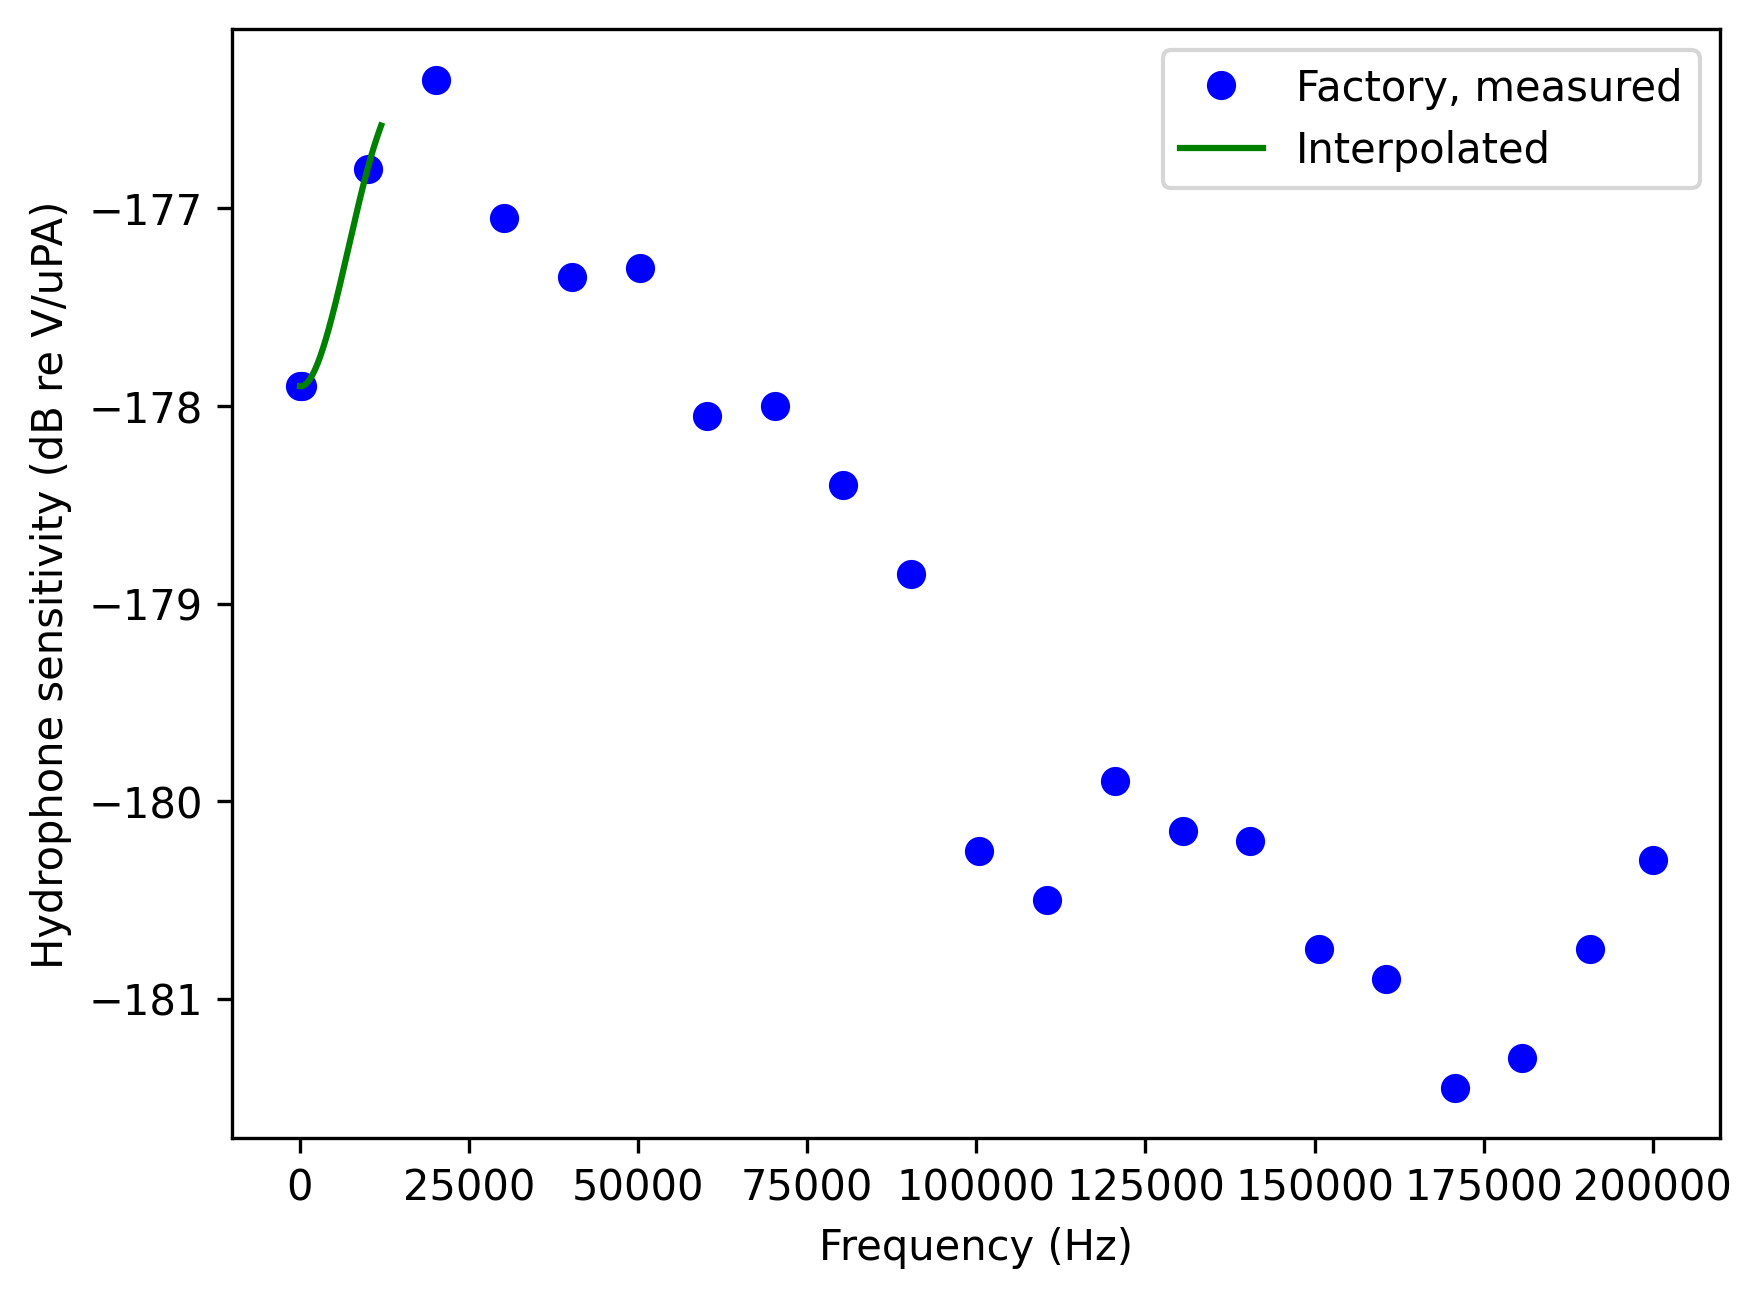

In [ ]:
# define hydrophone calibration data
calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

# interpolate to the frequency resolution of the spectrogram
tck = interpolate.splrep(calfreq, calsens, s=0)
isens = interpolate.splev(f_input, tck, der=0)
plt.figure(dpi=300)
im = plt.plot(calfreq,calsens,'bo',f_input,isens,'g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hydrophone sensitivity (dB re V/uPA)')
plt.legend(['Factory, measured', 'Interpolated'])


In [ ]:
# replicate interpolated sensitivity
isensg = np.transpose(np.tile(isens,[nseg,1]))
isensg.shape

(16385, 600)

In [ ]:
sg_input.shape

(16385, 600)

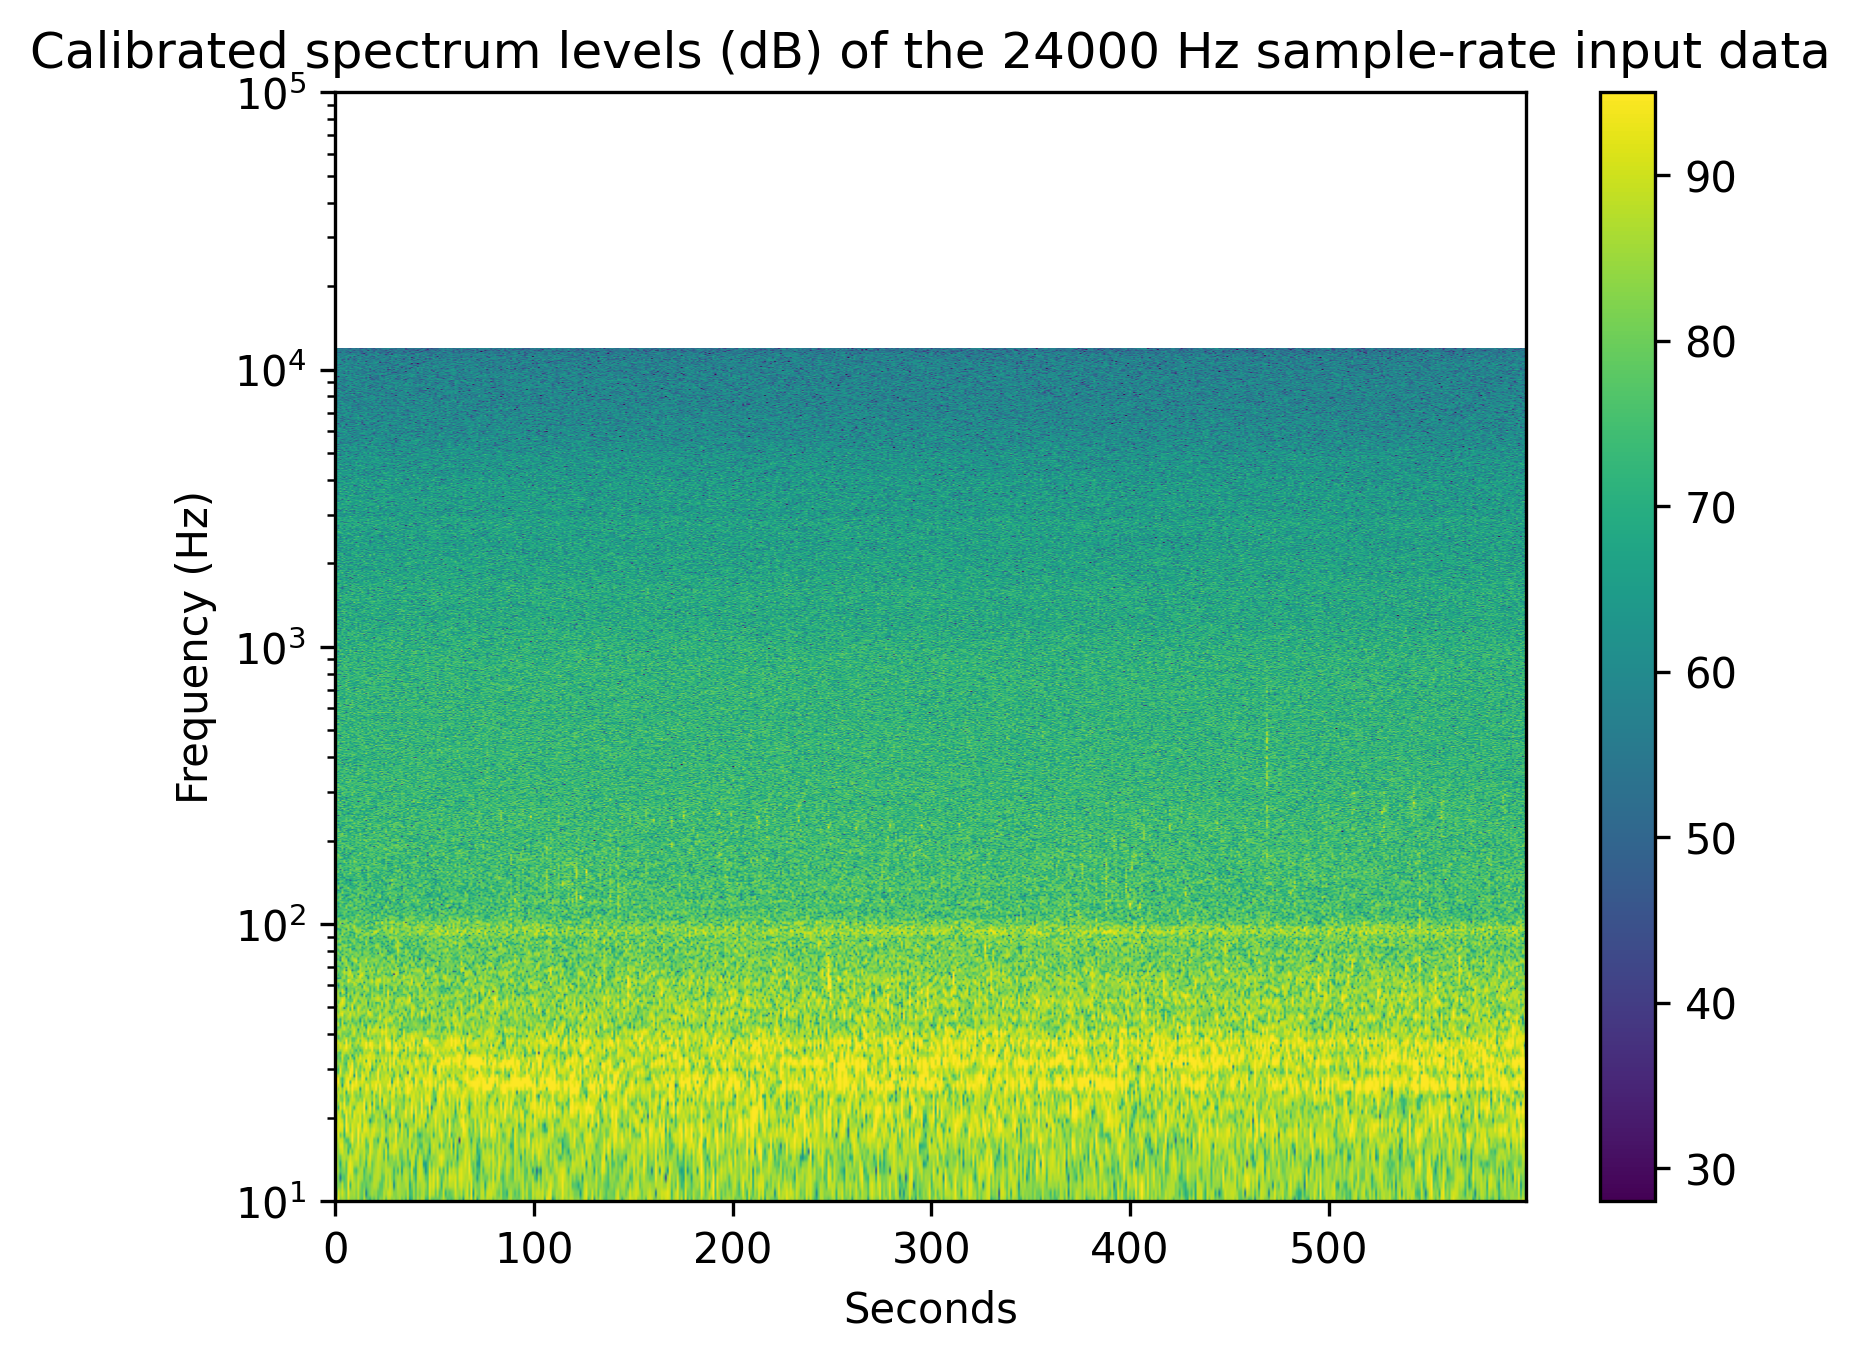

In [ ]:
plt.figure(dpi=300)
# plot calibrated
Extent = [0, nseg-1, 0.0, sample_rate/2.0]
im = plt.imshow(sg_input-isensg, extent=Extent, aspect='auto',origin='lower',vmin=28,vmax=95)
#plot uncalibrated
#im = plt.imshow(sg_input,aspect='auto',origin='lower',vmin=28,vmax=95)
plt.yscale('log')
plt.ylim(10,100000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title(f'Calibrated spectrum levels (dB) of the {sample_rate} Hz sample-rate input data')
plt.savefig(f'24kHz_{basefilename}.png')


In [ ]:
#copy to save spectrogram
copy_file('/content', '/content/drive/MyDrive/audio_spectrograms',f'24kHz_{basefilename}.png')
#copy_file('/content', '/content/drive/MyDrive/audio_spectrograms_dn',f'24kHz_{basefilename}.png')

File '24kHz_MARS_20180430_032912.png' copied from '/content' to '/content/drive/MyDrive/audio_spectrograms'.


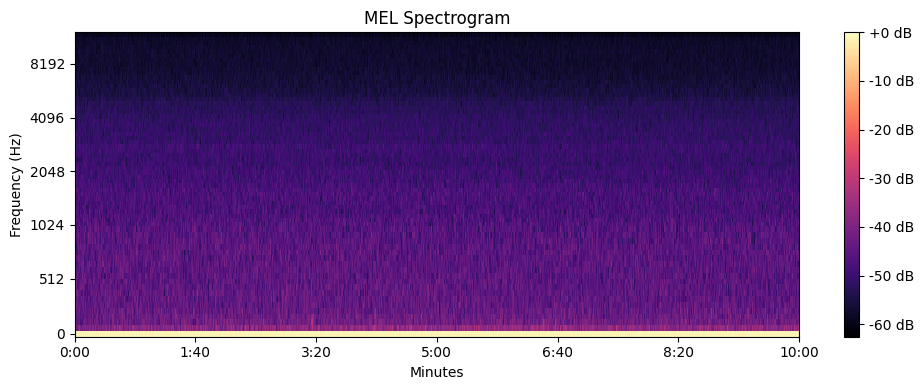

In [ ]:
audio_file_path = f'/content/drive/MyDrive/pacific-sound/24kHz_{basename}'
plot_mel_spectrogram(audio_file_path)


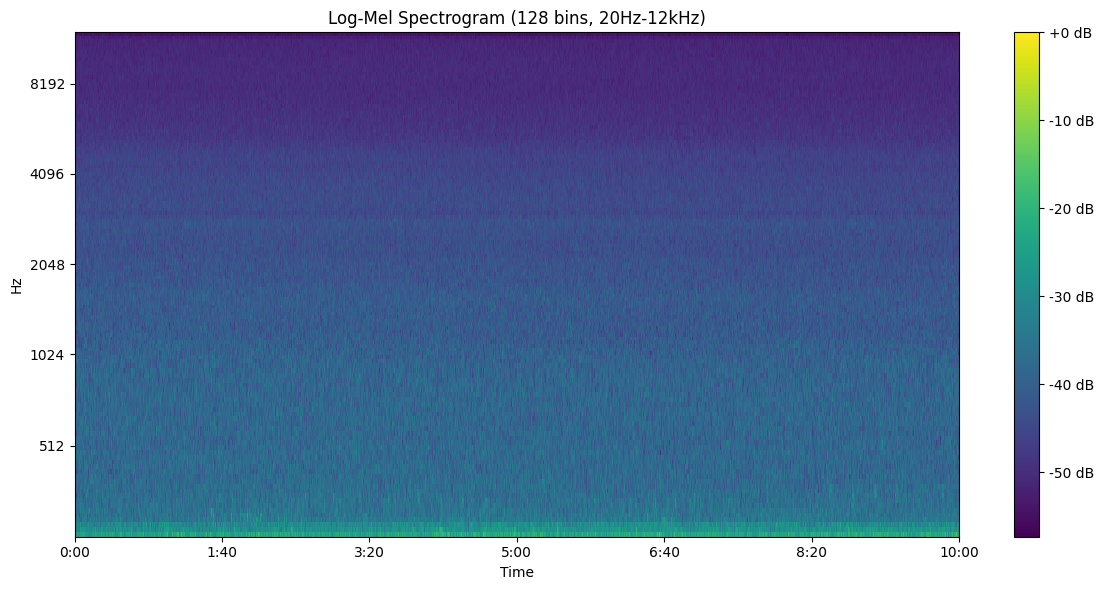

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot a spectrogram transforming an audio with standard STFT, Hann window of 200ms,
# hop of 30ms, non-trained log mel spectrogram with 128 bins from 20Hz to 12kHz


import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


# Load an audio file (replace with your own file path)
audio_path = f'/content/drive/MyDrive/pacific-sound/24kHz_{basename}'  # Change this to your audio file
y, sr = librosa.load(audio_path, sr=None)  # sr=None preserves original sampling rate

# STFT parameters
n_fft = int(0.20 * sr)  # 200ms window
hop_length = int(0.030 * sr)  # 30ms hop
win_length = n_fft  # window length = n_fft
window = 'hann'  # Hann window

# Compute STFT
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                 win_length=win_length, window=window)

# Convert to power spectrogram
S_power = np.abs(D) ** 2

# Create Mel filter bank
n_mels = 128
fmin = 20.0  # 20Hz minimum frequency
fmax = 12000.0  # 12kHz maximum frequency

# with no break frequency
mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft,
                               n_mels=n_mels,
                               fmin=fmin, fmax=fmax,
                               htk=False)  # Using Slaney mel scale

# Apply Mel filter bank to power spectrogram
S_mel = np.dot(mel_basis, S_power)

# Convert to log scale (dB)
S_log_mel = librosa.power_to_db(S_mel, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_log_mel, sr=sr,
                        hop_length=hop_length,
                        x_axis='time', y_axis='mel',
                        fmin=fmin, fmax=fmax, cmap='viridis',htk=False)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram (128 bins, 20Hz-12kHz)')
plt.tight_layout()
plt.show()
plt.savefig(f'24kHz_MEL_{basefilename}.png')


In [ ]:
#stop here
import sys
sys.exit("Stop execution")

SystemExit: Stop execution

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
rename_file(f'/content/MEL_{basefilename}.png',f'/content/MEL_24kHz_{basefilename}.png')
copy_file('/content', '/content/drive/MyDrive/audio_spectrograms',f'MEL_24kHz_{basefilename}.png')

In [ ]:
audio_file_path = f'/content/drive/MyDrive/pacific-sound/24kHz_normalized_{basename}'
plot_mel_spectrogram(audio_file_path)

In [ ]:
rename_file(f'/content/MEL_{basefilename}.png',f'/content/MEL_24kHz_normalized_{basefilename}.png')
copy_file('/content', '/content/drive/MyDrive/audio_spectrograms',f'MEL_24kHz_normalized_{basefilename}.png')


In [ ]:
# Record the end time
end_time = time.time()

# Calculate the difference between start and end time
time_difference = end_time - start_time

# Convert the time difference to a human-readable format
time_difference_formatted = str(timedelta(seconds=time_difference))

# Output the results
print(f"Start Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
print(f"End Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Time Difference: {time_difference_formatted}")

In [ ]:
#import os

def delete_files_by_extension(directory, extension):
    """
    Deletes all files with the specified extension in the given directory.

    Parameters:
        directory (str): Path to the directory where files should be deleted
        extension (str): File extension to match (without dot, e.g. 'txt' not '.txt')

    Returns:
        int: Number of files deleted
    """
    if not os.path.isdir(directory):
        raise ValueError(f"The specified directory does not exist: {directory}")

    deleted_count = 0

    try:
        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            # Check if the file ends with the specified extension
            if filename.endswith(f'.{extension}'):
                file_path = os.path.join(directory, filename)
                try:
                    # Check if it's a file (not a directory)
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        deleted_count += 1
                        print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")

        print(f"\nTotal files deleted: {deleted_count}")
        return deleted_count

    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

In [ ]:
##clean up if running repeatedly
#delete_files_by_extension('/content', 'wav')
#delete_files_by_extension('/content', 'png')